In [1]:
"""
coherence-based dual mic speech enhancemnet

Author:
    Wang Wei
"""
import argparse
from time import time

import numpy as np
from scipy.signal import windows

from DistantSpeech.adaptivefilter.FastFreqLms import FastFreqLms
from DistantSpeech.beamformer.MicArray import MicArray
from DistantSpeech.beamformer.beamformer import beamformer
from DistantSpeech.beamformer.utils import load_audio as audioread
from DistantSpeech.beamformer.utils import save_audio as audiowrite
from DistantSpeech.beamformer.utils import visual
from DistantSpeech.transform.transform import Transform
from DistantSpeech.noise_estimation import McSpp
from DistantSpeech.beamformer.FDGSC import FDGSC, DelayObj

import librosa
import matplotlib.pyplot as plt
from DistantSpeech.transform.transform import Transform
from DistantSpeech.beamformer.utils import pmesh, mesh, load_wav, save_audio, load_pcm, pt, load_pcm
from DistantSpeech.beamformer.utils import load_audio as audioread
from DistantSpeech.beamformer.utils import save_audio as audiowrite
from DistantSpeech.beamformer.beamformer import beamformer
from DistantSpeech.beamformer.MicArray import MicArray, compute_tau
from DistantSpeech.noise_estimation import McSpp, McSppBase
from DistantSpeech.transform.subband import Subband
from DistantSpeech.adaptivefilter.SubbandLMS import SubbandLMS
from DistantSpeech.beamformer.utils import DelaySamples, DelayFrames
from DistantSpeech.dereverberation.awpe import Wpe
from DistantSpeech.coherence.BinauralEnhancement import BinauralEnhancement
from DistantSpeech.noise_estimation.omlsa_multi import NsOmlsaMulti

from pesq import pesq
from pystoi.stoi import stoi

In [2]:
def power_to_db(x, amin=1e-3):
    db = 10.0 * np.log10(np.maximum(amin, x))

    return db

[[ 0.0225  0.      0.    ]
 [-0.0225  0.      0.    ]]
[2.65 1.5  0.5 ]
[2.5 2.5 0.5]
The RT60 is 86 ms
(2, 96279)


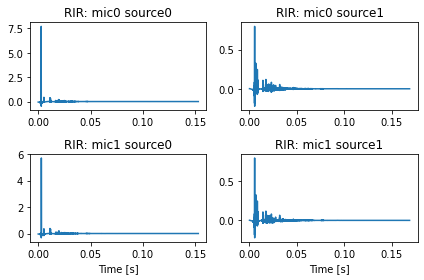

In [3]:
sampling_frequency = 16000
fft_length = 512
fft_shift = 256
mic_diameter = 0.045
sound_speed = 343
look_direction = 0
interf_angle = 90

signal = audioread("/home/wangwei/work/DistantSpeech/samples/audio_samples/5_541_20170608093550_3.wav")
signal = audioread("/home/wangwei/work/DistantSpeech/samples/audio_samples/5_541_20170608093550_5.wav")
noise = audioread("/home/wangwei/work/DistantSpeech/samples/audio_samples/cleanspeech_aishell3.wav")
# noise = audioread("/home/wangwei/work/DistantSpeech/samples/noise/office3.wav")

# signal = audioread("/home/wangwei/work/DistantSpeech/samples/audio_samples/5_541_20170608093550_4.wav")
# # signal = audioread("/home/wangwei/work/DistantSpeech/samples/audio_samples/cleanspeech_aishell3.wav")
# noise = audioread("/home/wangwei/work/DistantSpeech/samples/noise/office3.wav")

fs = 16000
M = 2
mic_array = MicArray(arrayType="linear", r=mic_diameter, M=M, n_fft=512, energy_absorption=0.55, room_size=[5.0,3.0,3.0])
print(mic_array.mic_loc)
mic_array_sim = mic_array.array_sim
# print(mic_array_sim.R)
array_data, premix = mic_array_sim.generate_audio(signal, interference=noise, source_angle=look_direction, interf_angle=interf_angle, sir=5, snr=20, source_distance=0.15, interf_distance=1.0)
theoretical=True
audiowrite('coherence/mix.wav', np.transpose(array_data))
audiowrite('coherence/signal.wav', np.transpose(premix[0, :, :]))
audiowrite('coherence/interf.wav', np.transpose(premix[1, :, :]))

# array_data = audioread('coherence/mix.wav')
# array_data = array_data.T

# array_data, _ = load_wav('/home/wangwei/work/DistantSpeech/example/coherence/xmos/wav')
# array_data = array_data[[1,0], :]
# print(array_data.shape)

# array_data = load_pcm('/home/wangwei/work/DistantSpeech/example/wpe/pcm')
# array_data = load_pcm('/home/wangwei/work/DistantSpeech/example/wpe/10_nearend')

print(array_data.shape)
M = array_data.shape[0]
transform = Transform(n_fft=512, hop_length=256, channel=M)
# D = transform.stft(np.transpose(array_data))
# # transform = Transform(n_fft=512, hop_length=256, channel=M)
# # target = transform.stft(np.transpose(premix[0, :M, :]))
# # transform = Transform(n_fft=512, hop_length=256, channel=M)
# # Noise = transform.stft(np.transpose(premix[1, :M, :]))
# # print(Noise.shape)
# half_bin = D.shape[0]
# frame_num = D.shape[1]
# print(D.shape)
# # plt.figure(figsize=(14,8))
# # plt.plot(mic_array_sim.room.rir[0][0][:10240])
# # plt.show()
# # array_data = array_data[:, :160000]
# pt(array_data[0, :])

In [4]:
frameLen = 512
n_fft = frameLen
hop = int(frameLen / 2)
overlap = frameLen - hop
# nfft = frameLen*2
# c = 340
# r = 0.032
# fs = 16000

# start = tim
# subband_lms = SubbandLMS(filter_len=2, num_bands=512, mu=1e-1) # use nyq subband
# aic = SubbandLMS(filter_len=2, num_bands=512, mu=1e-1) # use nyq subband
# transform = Transform(n_fft=512, hop_length=256, channel=M)
# # spp.mcra.L = 10

# mcspp = McSpp(nfft=512, channels=M)
# transform = Transform(n_fft=512, hop_length=256, channel=M)
# D = transform.stft(np.transpose(array_data))
# p = np.zeros((half_bin, D.shape[1]))
# for n in range(D.shape[1]):
#     y = D[:, n, :]  # [half_bin, M]
#     p[:, n] = mcspp.estimation(y)

# pmesh(p)

n_fft = 256
hop_length = 64

dualMIC_Enhancement = BinauralEnhancement(mic_array, frameLen=frameLen, hop=hop_length, nfft=n_fft, d=mic_diameter)
transform = Transform(n_fft=n_fft, hop_length=hop_length, channel=M)
# self.transform_d = Subband(n_fft=num_bands, hop_length=self.hop_length, channel=self.channels)


src = array_data[0]
data = array_data[1]
valid_len = array_data.shape[1]-frameLen  # discard last frame
print('valid_len:{}'.format(valid_len))

flms = FastFreqLms(filter_len=hop_length, mu=0.1)

valid_len = len(src)-flms.filter_len  # discard last frame

est_err_lms = np.zeros(valid_len)
est_err_nlms = np.zeros(valid_len)
est_err_flms = np.zeros(valid_len)

output = np.zeros(data.shape)


output_fbf = np.zeros(data.shape)
output_bm = np.zeros(data.shape)
output_aic = np.zeros(data.shape)

# delay_fbf = DelaySamples(hop, frameLen+hop)
# delay_p = DelayFrames(half_bin, 2)

yout = np.zeros((data.shape[0], M))
t = 0
snr = np.zeros((int(n_fft/2+1), 1))
frame_cnt = 0
from tqdm import tqdm
for n in tqdm(range((valid_len))):
    if np.mod(n, hop_length) == 0:
        input_vector = array_data[:, n: n +  hop_length].T

        output, snr_n = dualMIC_Enhancement.process(input_vector)
        # snr = np.squeeze(np.hstack((snr,snr_n)))
        yout[n: n +  hop_length, :] = output

        # output, w_flms = flms.update(input_vector[:, 0], input_vector[:, 1])

        # err, W = wpe.update(input_vector)
        # yout[n: n +  hop_length] = output[:,0]

        if t * hop_length > 60000 and t * hop_length < 80000:
            Fvv = dualMIC_Enhancement.Fvv_est

        t = t+1



valid_len:95767


100%|██████████| 96215/96215 [00:04<00:00, 21313.57it/s]


In [5]:
audiowrite('coherence/yout.wav', yout)

(257, 375, 2)
140407323753328


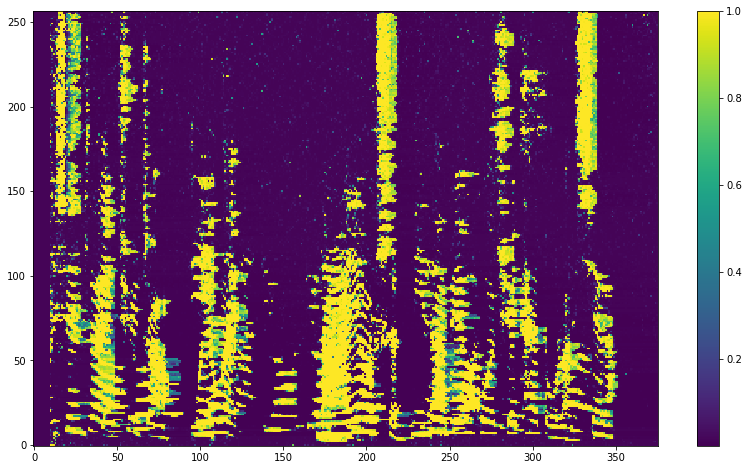

(257, 376, 2)
140405167259696


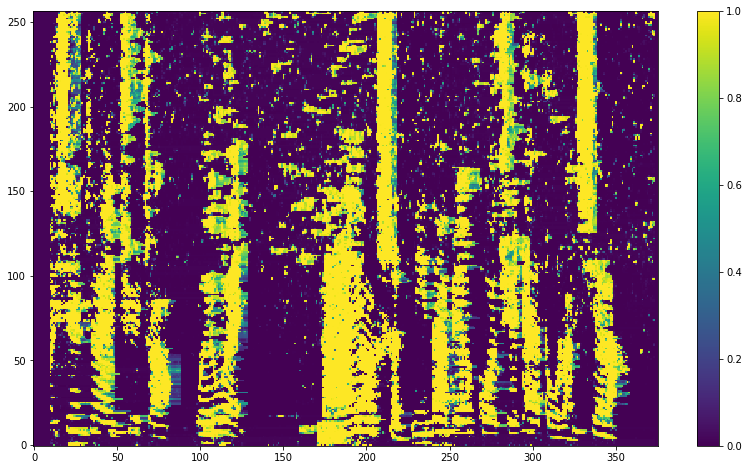

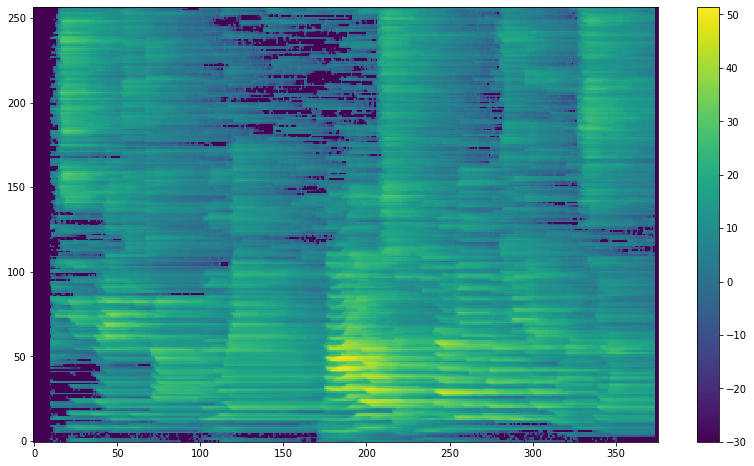

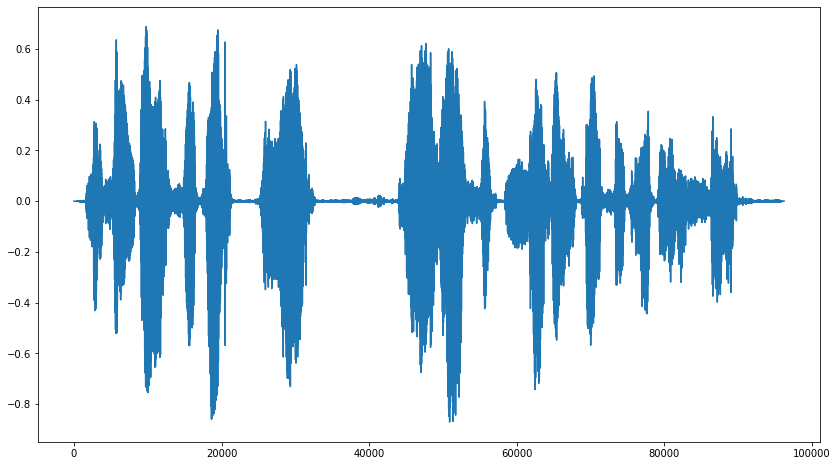

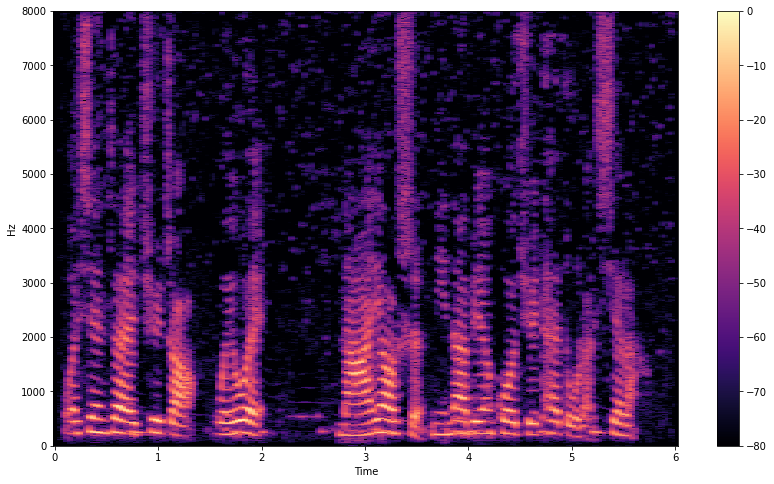

In [6]:
from DistantSpeech.beamformer.fixedbeamformer import FixedBeamformer
from DistantSpeech.noise_estimation import McSpp

transform_yout = Transform(n_fft=512, hop_length=256, channel=M)
Coh_out = transform_yout.stft(yout[256:])
print(Coh_out.shape)

fdgsc = FDGSC(mic_array, frameLen=256)

bm, fdgsc_p = fdgsc.process(array_data)
print(id(fdgsc_p))
pmesh(fdgsc_p)

spp = McSpp(nfft=512, channels=2)
spp.mcra.L = 10
transform = Transform(n_fft=512, hop_length=256, channel=M)
# Y = transform.stft(np.transpose(array_data[[0, -1], :]))
Y = transform.stft(yout)
print(Y.shape)
Yout = np.zeros((Y.shape[0], Y.shape[1]), dtype=complex)
Yout1 = np.zeros((Y.shape[0], Y.shape[1]), dtype=complex)
Yout2 = np.zeros((Y.shape[0], Y.shape[1]), dtype=complex)
xi = np.zeros((Y.shape[0], Y.shape[1]))
p = np.zeros((Y.shape[0], Y.shape[1]))
for n in range(Y.shape[1]-2):
    Yn = Y[:, n, :]
    p[:, n] = spp.estimation(Y[:, n, :])
    p[:, n] = np.sqrt(spp.p[:])

    spp.compute_omlsa_weight(spp.xi, p[:, n])
    xi[:, n] = spp.xi
    Yout[:, n] = spp.G * Yn[:, 0]

    Yout1[:, n] = np.sqrt(spp.G) * Yn[:, 0]
    Yout2[:, n] = np.sqrt(spp.G) * Yn[:, 1]

    Yout[:, n] = spp.G * Coh_out[:, n, 0]
    # Yout[:, n] = np.einsum('ij, ij->i', spp.G, Yn)
    # Yout1[:, n] = np.einsum('ij, ij->i', spp.w.conj(), Yn)
print(id(p))
y = transform.istft(Yout1[..., None])
y_coh = transform_yout.istft(Yout[..., None])
pmesh(p)
pmesh(power_to_db(xi))
pt(y)
visual(y)
audiowrite('coherence/yout_coh_omlsa.wav', y)


In [7]:
transform_yout1 = Transform(n_fft=512, hop_length=256, channel=1)
transform_yout2 = Transform(n_fft=512, hop_length=256, channel=1)

yout1 = transform_yout1.istft(Yout1[..., None])
yout2 = transform_yout1.istft(Yout2[..., None])
yout3 = np.hstack((yout1[:, None],yout2[:, None]))
print(yout3.shape)
dualMIC_Enhancement = BinauralEnhancement(mic_array, frameLen=frameLen, hop=hop_length, nfft=n_fft, d=mic_diameter)
yout = np.zeros(data.shape)
t = 0
snr = np.zeros((int(n_fft/2+1), 1))
frame_cnt = 0
from tqdm import tqdm
for n in tqdm(range((valid_len))):
    if np.mod(n, hop_length) == 0:
        input_vector = yout3[n: n +  hop_length, :]

        output, snr_n = dualMIC_Enhancement.process(input_vector)
        # snr = np.squeeze(np.hstack((snr,snr_n)))
        yout[n: n +  hop_length] = output[:]

        # output, w_flms = flms.update(input_vector[:, 0], input_vector[:, 1])

        # err, W = wpe.update(input_vector)
        # yout[n: n +  hop_length] = output[:,0]

        if t * hop_length > 60000 and t * hop_length < 80000:
            Fvv = dualMIC_Enhancement.Fvv_est

        t = t+1
pt(yout)
audiowrite('coherence/yout1.wav', yout1)
audiowrite('coherence/yout2.wav', yout2)
audiowrite('coherence/yout_omlsa_coh.wav', yout)

(96256, 2)


  0%|          | 0/96215 [00:00<?, ?it/s]


ValueError: could not broadcast input array from shape (64,2) into shape (64,)

In [ ]:





fixedbeamformerObj = FixedBeamformer(mic_array, nfft=512)
fixedbeamformerObj.compute_weights(look_angle=[0,0])
yout_fixedbf = fixedbeamformerObj.process(array_data.T)
yout_fixedbf = array_data[0]



transform_y = Transform(n_fft=512, hop_length=256, channel=1)
transform_u = Transform(n_fft=512, hop_length=256, channel=1)
D = transform_y.stft(yout_fixedbf)     # [F,T,Ch]
print(D.shape)
Y, _ = transform_y.magphase(D, 2)
Y = Y[:, 1:, :]

u = transform_u.stft(bm)     # [F,T,Ch]
U, _ = transform_u.magphase(u, 2)

print(Y.shape)
pmesh(librosa.power_to_db(Y[:, :, -1]))
plt.savefig('pmesh.png')

omlsa_multi = NsOmlsaMulti(nfft=512, cal_weights=True, M=2)
noise_psd = np.zeros((Y.shape[0], Y.shape[1]))
p = np.zeros((Y.shape[0], Y.shape[1]))
Yout = np.zeros((Y.shape[0], Y.shape[1]), dtype=type(Y))
y = np.zeros(array_data.shape[1])

# start = time.process_time()

for n in range(Y.shape[1]):
    omlsa_multi.estimation(Y[:, n, 0], U[:, n, 0:1])
    noise_psd[:, n] = omlsa_multi.lambda_d
    p[:, n] = omlsa_multi.p
    Yout[:, n] = D[:, n, 0] * (omlsa_multi.G)
    # Yout[:, n] = D[:, n, 0] * np.sqrt(p[:, n]/(1+p[:, n]))

# end = time.process_time()
# print(end - start)
# print(Yout)
print(Yout.shape)
# mesh(np.abs(Yout.real))
pmesh(p)
y = transform_y.istft(Yout[..., None])
pt(y)
visual(y)
audiowrite('coherence/yout_omlsa_multi.wav', y)
audiowrite('coherence/yout_bm.wav', bm)

In [ ]:

pmesh(power_to_db(snr+1e-3))

In [ ]:
print(mic_array.mic_loc)
# pt(np.abs(dualMIC_Enhancement.Fvv_est[:, 0, 1]), dualMIC_Enhancement.Fvv[:, 0, 1])
pt(np.abs(Fvv[:, 0, 1]), dualMIC_Enhancement.Fvv[:, 0, 1])
pt(Fvv[:, 0, 1].imag, dualMIC_Enhancement.Fvv[:, 0, 1])

In [ ]:
audiowrite('coherence/dereverb2.wav', yout)
print(data.shape)
# print(err.shape)
pt(yout)
print(np.max(yout))
visual(data)
visual(yout)
# you1 = yout.copy()
# yout[yout>1.0] = 1.0
# yout[yout<-1.0] = -1.0
# visual(yout)
# pt(yout)

In [ ]:
# nsy = array_data[0, :]
# ref = signal
# sr = 16000
# # enh = audioread("/home/wangwei/work/DistantSpeech/samples/noise/office1.wav")
# # enh = audioread("/home/wangwei/work/DistantSpeech/example/out2.wav")
# # enh = audioread("/home/wangwei/work/nn-gev-master/nn_gev2.wav")
# # enh = enh[512:]
# enh = output_aic[frameLen:]
# nsy = nsy[: len(enh)]
# ref = ref[: len(enh)]

# offset = 20480 # skip unconverge segment
# enh = enh[offset:]
# nsy = nsy[offset:]
# ref = ref[offset:]

# summary = {
#     'ref_pesq_wb': pesq(sr, ref, nsy, 'wb'),
#     'enh_pesq_wb': pesq(sr, ref, enh, 'wb'),
#     'ref_pesq_nb': pesq(sr, ref, nsy, 'nb'),
#     'enh_pesq_nb': pesq(sr, ref, enh, 'nb'),
#     'ref_stoi': stoi(ref, nsy, sr, extended=False),
#     'enh_stoi': stoi(ref, enh, sr, extended=False),
#     'ref_estoi': stoi(ref, nsy, sr, extended=True),
#     'enh_estoi': stoi(ref, enh, sr, extended=True),
# }
# for key in summary.keys():
#     print('{}:{}'.format(key, summary[key]))